In [90]:
import os
import pickle
import pandas as pd
import numpy as np
from matplotlib.patches import Patch
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import re
import json
from matplotlib.lines import Line2D
from matplotlib.legend_handler import HandlerTuple
import statistics

In [91]:
markers = ['o', '*', 'v', '^', '<', 's']
sns.set_palette(palette=['#AC2C0C', '#3A7E5E', '#495867','#577399','#BDD5EA','#B5CA8D'])
plt.rcParams.update({"text.usetex": True, "font.family" : "serif", "font.serif" : ["Computer Modern Serif"]})

In [92]:
# Load in files
directory = '../../raw_results'
file_name = "frankfurt_db=0.50_OC=1.5_model=fixed.pkl"


results_file = f'{directory}/{file_name}'
with open(results_file, 'rb') as file:
    sol = pickle.load(file)

In [93]:
# Calculate number of total packages
pattern = r'^(.+?)_OC'
base_name = re.search(pattern, file_name).group(1)

weekday_path = f'../../instances/{base_name}_dt=doublepeak.json'
weekend_path = f'../../instances/{base_name}_dt=uniform.json'


with open(weekday_path, 'r') as file:
    weekday = json.load(file)

with open(weekend_path, 'r') as file:
    weekend = json.load(file)

In [94]:
required_couriers = {}
hired_couriers_baseline = {}
hired_couriers_roster = {}


for region in sol['reg_areas']:
    for theta in range(8):
        for area in sol['reg_areas'][region]:
                for day in range(7):
                    hired_couriers_roster[area, theta, day] = sum((employee, a, period, d) in sol['k'] for employee, a, period, d in sol['k'] if period == theta and d == day and a == area)
                    hired_couriers_baseline[area, theta, day] = sum((employee, a, period, d) in sol['baseline']['k'] for employee, a, period, d in sol['baseline']['k'] if period == theta and d == day and a == area)

                    if day < 5:
                        required_couriers[area, theta, day]  = round(sum(area_data['required_couriers'][theta] for scenario in weekday['scenarios'] for area_data in scenario['data'] if area_data['area_id'] == area)/weekday['num_scenarios'])
                    else:
                        required_couriers[area, theta, day]  = round(sum(area_data['required_couriers'][theta] for scenario in weekend['scenarios'] for area_data in scenario['data'] if area_data['area_id'] == area)/weekend['num_scenarios'])
            

In [95]:
required_couriers_regional = {}
hired_couriers_baseline_regional = {}
hired_couriers_roster_regional = {}

for region in sol['reg_areas']:
    for theta in range(8):
        for day in range(7):
            hired_couriers_roster_regional[region, theta, day] = 0
            hired_couriers_baseline_regional[region, theta, day] = 0
            required_couriers_regional[region, theta, day] = 0
            for area in sol['reg_areas'][region]:
            
                    hired_couriers_roster_regional[region, theta, day] += hired_couriers_roster[area, theta, day]
                    hired_couriers_baseline_regional[region, theta, day] += hired_couriers_baseline[area, theta, day]
                    required_couriers_regional[region, theta, day]  += required_couriers[area, theta, day]
            


# Required couriers

In [96]:
# Initialize an empty DataFrame with unique regions as index
regions = set(key[0] for key in required_couriers_regional.keys())
pt = pd.DataFrame(index=sorted(regions))

# Populate the DataFrame
for (region, theta, day), value in required_couriers_regional.items():
    column_name = f"{day}-{theta}"
    pt.loc[region, column_name] = value

# Sort columns to ensure they are in the correct order
pt = pt.sort_index(axis=1)
pt

,0-0,0-1,0-2,0-3,0-4,0-5,0-6,0-7,1-0,1-1,...,5-6,5-7,6-0,6-1,6-2,6-3,6-4,6-5,6-6,6-7
0,0.0,4.0,9.0,8.0,8.0,9.0,2.0,0.0,0.0,4.0,...,7.0,7.0,7.0,8.0,7.0,7.0,8.0,7.0,7.0,7.0
1,0.0,6.0,7.0,7.0,7.0,7.0,5.0,0.0,0.0,6.0,...,7.0,7.0,5.0,7.0,6.0,7.0,7.0,7.0,7.0,7.0
2,0.0,2.0,8.0,6.0,6.0,9.0,3.0,0.0,0.0,2.0,...,4.0,5.0,4.0,3.0,4.0,4.0,4.0,4.0,4.0,5.0
3,0.0,3.0,5.0,5.0,5.0,5.0,4.0,0.0,0.0,3.0,...,4.0,5.0,5.0,4.0,5.0,5.0,5.0,5.0,4.0,5.0


In [1]:
# plots
title_font = 25
fig, axs = plt.subplots(ncols=1, nrows=1, figsize=(30,3))

sns.heatmap(pt.astype(int), annot=True, ax=axs, cbar=False, cmap='Reds', fmt='g')

title = "Required couriers per region in Frankfurt  \n (\\texttt{DB} = 0.50) \n Weekday: \\textsc{DoublePeak} - Weekend: \\textsc{Uniform} \n "
axs.set_title(title, fontsize=title_font)
axs.set_ylabel('Regions', fontsize=16)
axs.set_xlabel('Time', fontsize=16)
plt.yticks(rotation=0)

# Assuming 'day_period' in the pivot table columns includes values like 'Mon_Morning', 'Mon_Afternoon', etc.
# Extract unique day names and periods for secondary x-axis labeling
days = sorted(list(set(label.split('-')[0] for label in pt.columns)))
periods = sorted(list(set(label.split('-')[1] for label in pt.columns)))

all_periods = list(label.split('-')[1] for label in pt.columns)
all_periods = [ f'{int(p)*2+6:02d}' + '\n' + f'{(int(p)+1)*2+6:02d}' for p in all_periods]

spacers = '--------------------'
days = [ 'I' + spacers + '  ' + str(day) + '  '+ spacers + 'I' for day in days]

# Set xticks for the secondary x-axis
axs.set_xticks(np.arange(len(pt.columns)) + 0.5)
axs.set_xticklabels(all_periods, fontsize=16)

# Create secondary x-axis
secax = axs.secondary_xaxis('top')
secax.set_xticks(np.arange(len(days)) * len(periods) + len(periods) / 2)
secax.set_xticklabels(days, fontsize=16)

axs.set_yticklabels(axs.get_yticklabels(), fontsize=16)

#plt.tight_layout()
fig.savefig(f'Frankfurt required couriers.png', dpi=96, bbox_inches='tight')

plt.show()

NameError: name 'plt' is not defined

# Baseline

In [98]:
# Initialize an empty DataFrame with unique regions as index
regions = set(key[0] for key in hired_couriers_baseline_regional.keys())
pt = pd.DataFrame(index=sorted(regions))

# Populate the DataFrame
for (region, theta, day), value in hired_couriers_baseline_regional.items():
    column_name = f"{day}-{theta}"
    pt.loc[region, column_name] = value

# Sort columns to ensure they are in the correct order
pt = pt.sort_index(axis=1)
pt

,0-0,0-1,0-2,0-3,0-4,0-5,0-6,0-7,1-0,1-1,...,5-6,5-7,6-0,6-1,6-2,6-3,6-4,6-5,6-6,6-7
0,0.0,4.0,8.0,7.0,8.0,9.0,3.0,0.0,0.0,4.0,...,8.0,7.0,8.0,8.0,7.0,7.0,8.0,6.0,8.0,7.0
1,0.0,7.0,7.0,7.0,7.0,7.0,5.0,0.0,0.0,7.0,...,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0
2,0.0,2.0,7.0,6.0,6.0,8.0,2.0,0.0,0.0,2.0,...,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0
3,0.0,4.0,5.0,5.0,5.0,5.0,5.0,0.0,0.0,4.0,...,4.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,4.0,5.0


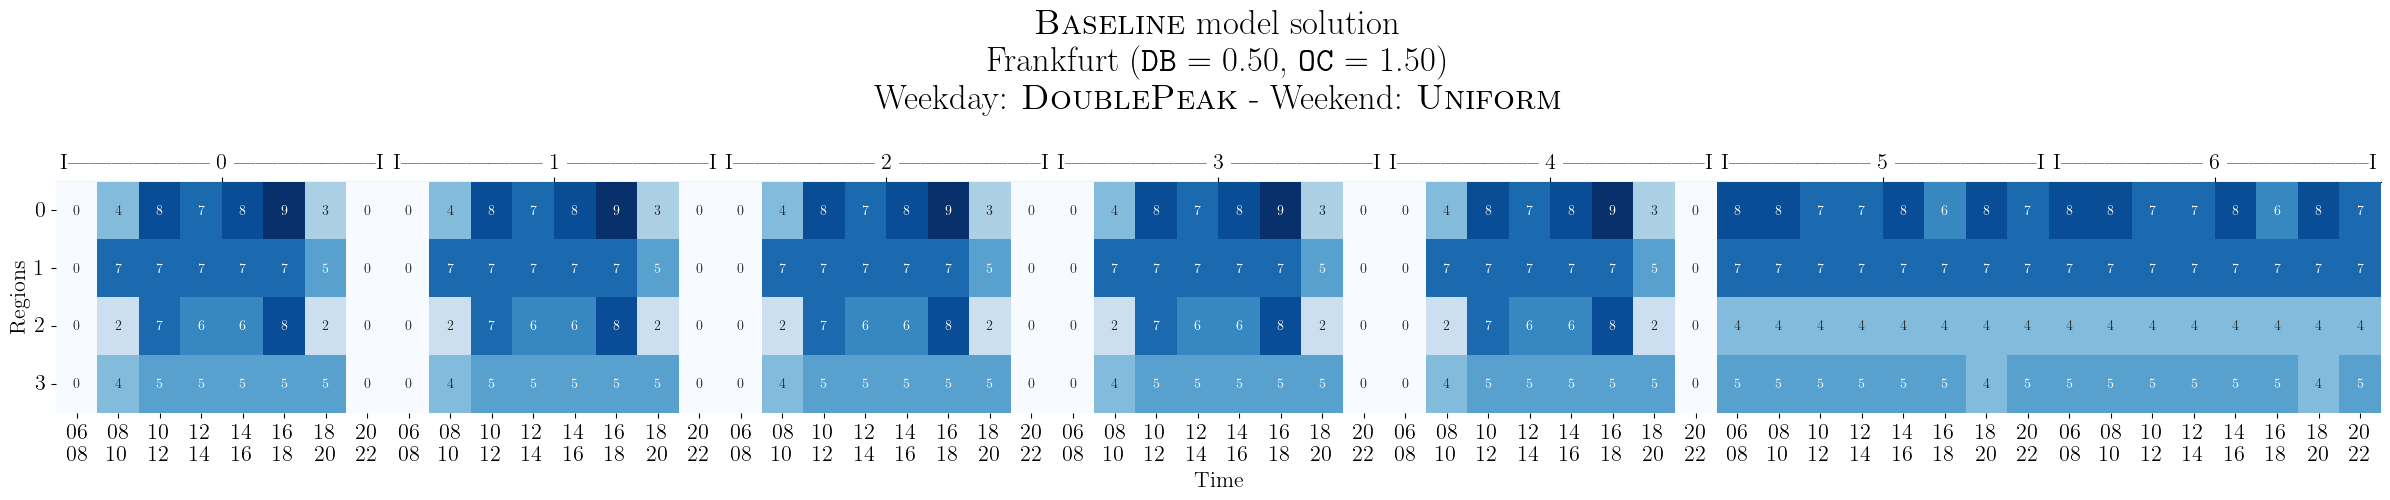

In [99]:
fig, axs = plt.subplots(ncols=1, nrows=1, figsize=(30,3))

sns.heatmap(pt, annot=True, ax=axs, cbar=False, cmap='Blues')

title = "\\textsc{Baseline} model solution \n Frankfurt (\\texttt{DB} = 0.50, \\texttt{OC} = 1.50) \n Weekday: \\textsc{DoublePeak} - Weekend: \\textsc{Uniform} \n"
axs.set_title(title, fontsize=title_font)
axs.set_ylabel('Regions', fontsize=16)
axs.set_xlabel('Time', fontsize=16)
plt.yticks(rotation=0)

# Assuming 'day_period' in the pivot table columns includes values like 'Mon_Morning', 'Mon_Afternoon', etc.
# Extract unique day names and periods for secondary x-axis labeling
days = sorted(list(set(label.split('-')[0] for label in pt.columns)))
periods = sorted(list(set(label.split('-')[1] for label in pt.columns)))

all_periods = list(label.split('-')[1] for label in pt.columns)
all_periods = [ f'{int(p)*2+6:02d}' + '\n' + f'{(int(p)+1)*2+6:02d}' for p in all_periods]

spacers = '--------------------'
days = [ 'I' + spacers + '  ' + str(day) + '  '+ spacers + 'I' for day in days]

# Set xticks for the secondary x-axis
axs.set_xticks(np.arange(len(pt.columns)) + 0.5)
axs.set_xticklabels(all_periods, fontsize=16)

# Create secondary x-axis
secax = axs.secondary_xaxis('top')
secax.set_xticks(np.arange(len(days)) * len(periods) + len(periods) / 2)
secax.set_xticklabels(days, fontsize=16)

# Create secondary y-axis
#secay = axs.secondary_yaxis('left')
#secay.set_xticks()
#secay.set_xticklabels(days, fontsize=18)
axs.set_yticklabels(axs.get_yticklabels(), fontsize=16)

#plt.tight_layout()
fig.savefig('frankfurt baseline.png', dpi=96, bbox_inches='tight')

plt.show()

# Fixed

In [100]:
# Initialize an empty DataFrame with unique regions as index
regions = set(key[0] for key in hired_couriers_roster_regional.keys())
pt = pd.DataFrame(index=sorted(regions))

# Populate the DataFrame
for (region, theta, day), value in hired_couriers_roster_regional.items():
    column_name = f"{day}-{theta}"
    pt.loc[region, column_name] = value

# Sort columns to ensure they are in the correct order
pt = pt.sort_index(axis=1)
pt

,0-0,0-1,0-2,0-3,0-4,0-5,0-6,0-7,1-0,1-1,...,5-6,5-7,6-0,6-1,6-2,6-3,6-4,6-5,6-6,6-7
0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,6.0,6.0,...,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0
1,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,...,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0
2,6.0,6.0,6.0,6.0,7.0,7.0,7.0,7.0,6.0,6.0,...,7.0,7.0,8.0,8.0,8.0,8.0,7.0,7.0,7.0,7.0
3,6.0,6.0,6.0,6.0,5.0,5.0,5.0,5.0,6.0,6.0,...,6.0,6.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0


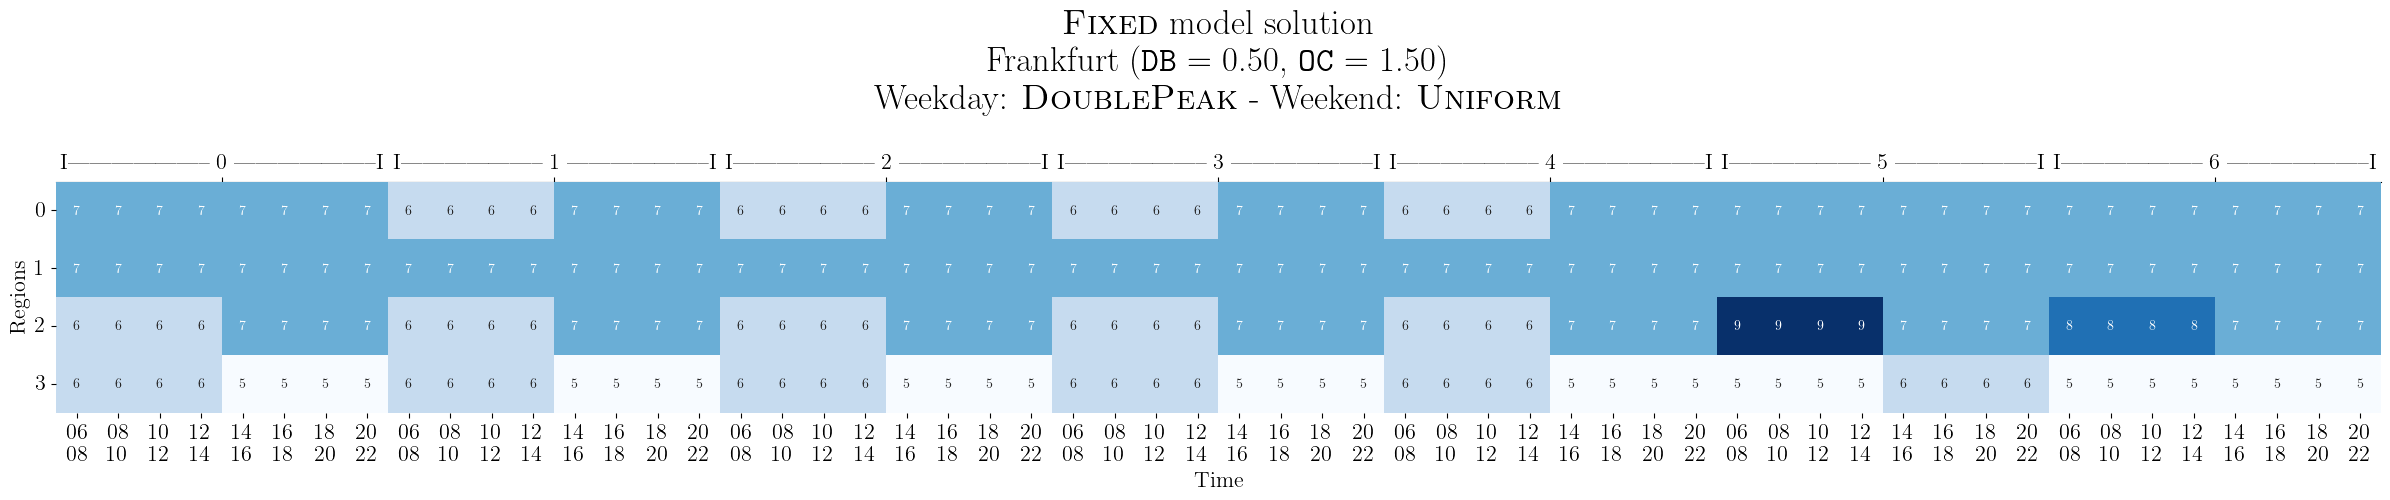

In [101]:
fig, axs = plt.subplots(ncols=1, nrows=1, figsize=(30,3))

sns.heatmap(pt, annot=True, ax=axs, cbar=False, cmap='Blues')

title = "\\textsc{Fixed} model solution \n Frankfurt (\\texttt{DB} = 0.50, \\texttt{OC} = 1.50) \n Weekday: \\textsc{DoublePeak} - Weekend: \\textsc{Uniform} \n"
axs.set_title(title, fontsize=title_font)
axs.set_ylabel('Regions', fontsize=16)
axs.set_xlabel('Time', fontsize=16)
plt.yticks(rotation=0)

# Assuming 'day_period' in the pivot table columns includes values like 'Mon_Morning', 'Mon_Afternoon', etc.
# Extract unique day names and periods for secondary x-axis labeling
days = sorted(list(set(label.split('-')[0] for label in pt.columns)))
periods = sorted(list(set(label.split('-')[1] for label in pt.columns)))

all_periods = list(label.split('-')[1] for label in pt.columns)
all_periods = [ f'{int(p)*2+6:02d}' + '\n' + f'{(int(p)+1)*2+6:02d}' for p in all_periods]

spacers = '--------------------'
days = [ 'I' + spacers + '  ' + str(day) + '  '+ spacers + 'I' for day in days]

# Set xticks for the secondary x-axis
axs.set_xticks(np.arange(len(pt.columns)) + 0.5)
axs.set_xticklabels(all_periods, fontsize=16)

# Create secondary x-axis
secax = axs.secondary_xaxis('top')
secax.set_xticks(np.arange(len(days)) * len(periods) + len(periods) / 2)
secax.set_xticklabels(days, fontsize=16)

# Create secondary y-axis
#secay = axs.secondary_yaxis('left')
#secay.set_xticks()
#secay.set_xticklabels(days, fontsize=18)
axs.set_yticklabels(axs.get_yticklabels(), fontsize=16)

#plt.tight_layout()
fig.savefig('frankfurt fixed.png', dpi=96, bbox_inches='tight')

plt.show()